In [150]:
# Load FashionMNIST Dataset
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import numpy as np
import importlib

# Reload custom modules in case of refresh
import custom_models
importlib.reload(custom_models)
from custom_models import AutoEncoder

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

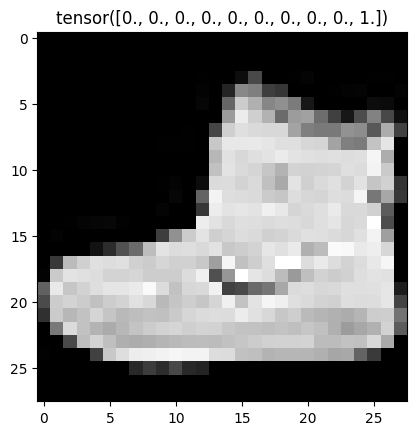

In [151]:
index = 0
img, label = training_data[index]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(label)
plt.show()

In [152]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device="cpu"
print(f"Using {device} device")

Using cpu device


In [153]:
model = AutoEncoder(
    input_dim = 28 * 28, 
    encoder_size = 3,
    decoder_size = 3,
    n_layers = 1, 
    layer_dim = 100).to(device)
print(model)

[Sequential(
  (0): Linear(in_features=784, out_features=556, bias=True)
  (1): ReLU()
), Sequential(
  (0): Linear(in_features=556, out_features=328, bias=True)
  (1): ReLU()
), Sequential(
  (0): Linear(in_features=328, out_features=100, bias=True)
  (1): ReLU()
)]
[Sequential(
  (0): Linear(in_features=100, out_features=328, bias=True)
  (1): ReLU()
), Sequential(
  (0): Linear(in_features=328, out_features=556, bias=True)
  (1): ReLU()
), Sequential(
  (0): Linear(in_features=556, out_features=784, bias=True)
  (1): ReLU()
)]
AutoEncoder(
  (Encoder): Linspace(
    (full_model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=784, out_features=556, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=556, out_features=328, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=328, out_features=100, bias=True)
        (1): ReLU()
      )
    )
  )
  (Decoder): Linspace(
    (full_mode

In [158]:
# Training loop
learning_rate = 1e-3
batch_size = 64
epochs = 10
# Initialize the loss function
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    t = tqdm(range(size), position=1, leave=False)
    with t as PB:
        for batch, (X, y) in enumerate(dataloader):
            # flatten image (y is ignored here)
            flat = X.reshape(-1, 28 * 28)
            # Compute prediction and loss
            pred = model(flat)
            loss = loss_fn(pred, flat)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                PB.set_description(f"\tTraining:\tloss: {loss:>4f}, curr: {current}")
            PB.update(batch_size)


def test_loop(dataloader, model, loss_fn, epoch, pbar=None):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            # flatten image (y is ignored here)
            flat = X.reshape(-1, 28 * 28)
            pred = model(flat)
            test_loss += loss_fn(pred, flat).item()
            # correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    # correct /= size
    output_text = f"Epoch {epoch}:\tTest Error: (Avg loss: {test_loss:>4f}) \n"
    if pbar:
        pbar.set_description(output_text)
        pbar.update(1)
    else:
        print(output_text)
    return test_loss, correct

In [ ]:
losses, corrects = [], []

In [163]:

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
p = tqdm(range(epochs), position=0)
# with p as outer:
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    L, C = test_loop(test_dataloader, model, loss_fn, t, p)
    losses.append(L)
    corrects.append(C)
print("Done!")

Epoch 0...:   0%|          | 0/10 [03:29<?, ?it/s]
Epoch 0:	Test Error: (Avg loss: 0.014376) 
Epoch 0:	Test Error: (Avg loss: 0.014376) 
Epoch 1:	Test Error: (Avg loss: 0.014276) 8s/it]
Epoch 1:	Test Error: (Avg loss: 0.014276) 8s/it]
Epoch 2:	Test Error: (Avg loss: 0.014208) 5s/it]
Epoch 2:	Test Error: (Avg loss: 0.014208) 5s/it]
Epoch 3:	Test Error: (Avg loss: 0.014035) 1s/it]
Epoch 3:	Test Error: (Avg loss: 0.014035) 1s/it]
Epoch 4:	Test Error: (Avg loss: 0.014015) 4s/it]
Epoch 4:	Test Error: (Avg loss: 0.014015) 4s/it]
Epoch 5:	Test Error: (Avg loss: 0.014047) 2s/it]
Epoch 5:	Test Error: (Avg loss: 0.014047) 2s/it]
Epoch 6:	Test Error: (Avg loss: 0.013894) 3s/it]
Epoch 6:	Test Error: (Avg loss: 0.013894) 3s/it]
Epoch 7:	Test Error: (Avg loss: 0.013844) 5s/it]
Epoch 7:	Test Error: (Avg loss: 0.013844) 5s/it]
Epoch 8:	Test Error: (Avg loss: 0.013672) 1s/it]
Epoch 8:	Test Error: (Avg loss: 0.013672) 1s/it]
Epoch 9:	Test Error: (Avg loss: 0.013541) 3s/it]
Epoch 9:	Test Error: (Avg loss

Done!


Text(0.5, 1.0, 'Final Loss: 0.013541309922269195')

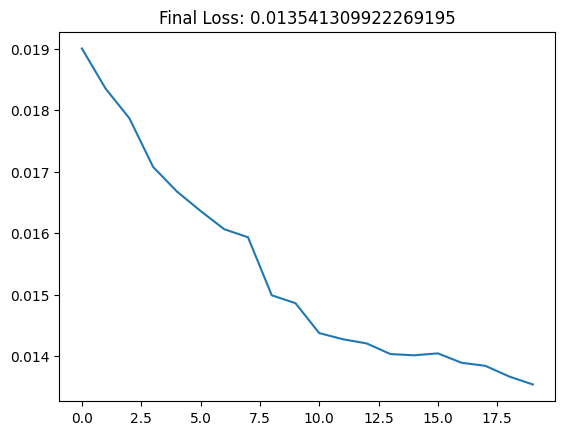

In [165]:
plt.plot(losses)
plt.title(f'Final Loss: {losses[-1]}')

In [142]:
index = 0
def show_pred(model, img, label):
    f, ax = plt.subplots(1,2)
    flat = img.reshape(-1, 28 * 28)
    pred = model(flat)
    pred_img = pred.reshape(-1, 28, 28)
    ax[0].imshow(img.squeeze(), cmap='gray')
    ax[1].imshow(pred_img.detach().squeeze(), cmap='gray')
    label_idx = np.argmax(label).detach().numpy()
    f.suptitle(class_names[label_idx])
    plt.show()

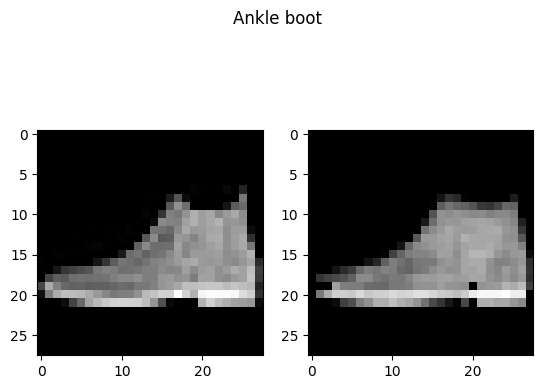

0.014705604719365857


In [143]:
show_pred(model, *test_data[index])
print(losses[-1])

In [169]:
# Additional information
EPOCH = 5
PATH = "model.pt"
LOSS = losses[-1]

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [170]:
checkpoint = torch.load(PATH)
loaded_model = AutoEncoder(
    input_dim = 28 * 28, 
    encoder_size = 3,
    decoder_size = 3,
    n_layers = 1, 
    layer_dim = 100).to(device)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loaded_opt.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(loss)

[Sequential(
  (0): Linear(in_features=784, out_features=556, bias=True)
  (1): ReLU()
), Sequential(
  (0): Linear(in_features=556, out_features=328, bias=True)
  (1): ReLU()
), Sequential(
  (0): Linear(in_features=328, out_features=100, bias=True)
  (1): ReLU()
)]
[Sequential(
  (0): Linear(in_features=100, out_features=328, bias=True)
  (1): ReLU()
), Sequential(
  (0): Linear(in_features=328, out_features=556, bias=True)
  (1): ReLU()
), Sequential(
  (0): Linear(in_features=556, out_features=784, bias=True)
  (1): ReLU()
)]
0.013541309922269195


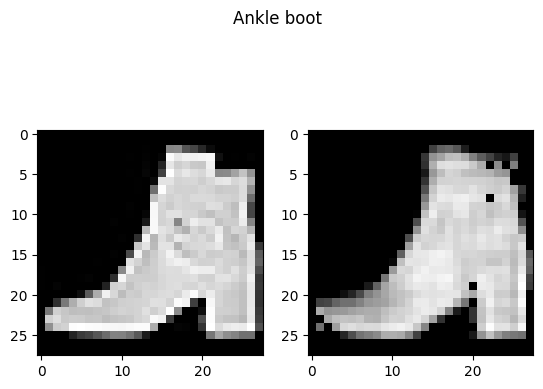

In [149]:
show_pred(loaded_model, *training_data[50301])

In [166]:
# Additional information
PATH = "autoencoder.model"

torch.save(model, PATH)